This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for text

## Natural-language processing: The bird's eye view

Language is how we store almost all of our knowledge. However, the ability to understand natural language has long eluded machines.
1960s: the famous ELIZA program used pattern matching to sustain very basic conversation.

1960s-1990s: Handcrafted rules held out as the dominant approach.

late 1980s: started seeing machine learning approaches to NLP

Moder NLP is about using ML and large datasets to give computers the ability to understand language.

1990s to early 2010s: the toolset of NLP (decision trees, logisitc regression, only saw slow evolution)
Most of the research focus was on feature engineering

2014-2015: Multiple researchers began to investigate the language-understanding capabilities of recurrent neural networks, LSTM

2015-2017:recurrent neural networks dominated the booming NLP scene : BilSTM

2017-2018: new architecture rose to replace RNNs: the Transformer, these days, most NLP systems are based on them

NLP Topics:

Text classification: What's the topic of this text?

Content filtering: Does this text contain abuse?

Sentiment analysis: Does this text sound positive or negative?

Langugage modeling: What should be the next word in this incomplete sentence?

Translation: How would you say this in German?

Summarization: How would you summarize this article in one paragraph?

## Preparing text data

Like all other Neural Networks, deep learning models don't take as input raw text: they only work with numeric tensors

Vectorizing text is the process of transforming text into numeric tensors


*   Standardize the text to make it easier to process, such as by converting it to lowercase or removing punctuation
*   Split the text into units (called tokens) such as characters, words, or groups of words. This is called tokenization
*   Convert each such token into a numerical vector. This will usually involve first indexing all tokens present in the data. 



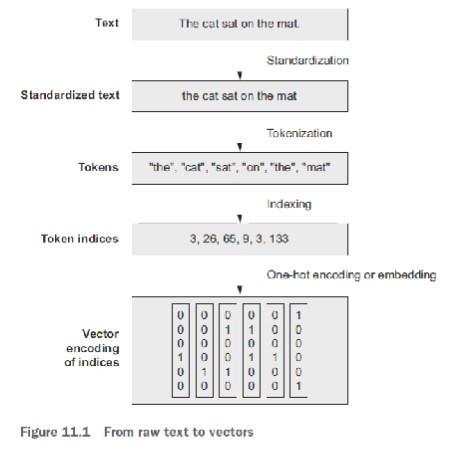

### Text standardization

Consider these 2 sentences

> "sunset came. i was staring at the Mexico sky.Isnt nature spendid??"


> "Sunset came; I stared at the México sky.Isn't nature splendid?"

Text standardization is a basic form of feature engineering that aims to erase encoding differences. Simplest and most widespread standardization schemes is "convert to lowercase and remove punctuation characters."


>  "sunset came i was staring at the mexico sky isnt nature spendid"


> "sunset came i stared at the méxico sky isnt nature spendid"










Another common transformation is to convert special characters to a standard form, such as replacing "é" with "e" and so on

stemming: converting variations of a term (such as different conjugated forms of a verb) into a single shared representation, like turning "caught" and "been catching" into "[catch]" or "cats" into "[cat]"

> "sunset came i [stare] at the mexico sky isnt nature splendid"

With these standardization techniques, your model will require less training data and will generalize better.




### Text splitting (tokenization)

Split the text into units (called tokens) such as characters, words or groups of words. This is called tokenization.


*   Word-level tokenization : where tokens are space-separated substrings. A variant of this is to further split words into subwords -- for instance, treating "staring" as "star+ing" or "called" as "call+ed"
*   N-gram tokenization : where tokens are groups of N consecutive words -- for instance, "the cat" or "he was" would be 2-gram tokens
*   Character-level tokenization: where each character is its own token. In practice, this cheme is rarely used, and you only really see it in specialized contexts, like text generation or speech recognition.

There are 2 kinds of text processing models: those that care about word order, called sequence models, and those that treat input words as a set, discarding their original order, called bag-of-words models.



Understanding n-grams and bag-of-words

Word n-grams are groups of N (or fewer) consecutive words that you can extract from a sentence

--example: "The cat sat on the mat."

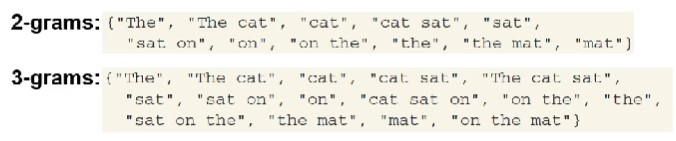

This family of tokenization methods is called bag-of-words

Bag-of-words isn't an order-preserving tokenization method

General structure of the sentences is lsot

Tends to be used in shallow language-processing models

Extracting n-grams is a form of feature engineering and deep learning models (RNN, 1D CNN, and Transformer) do away with this manual approach

### Vocabulary indexing

Need to encode each token into a numerical representation

Build an index of all terms found in the training data

In [1]:
vocabulary={}
for text in dataset:
  text=standardize(text)
  tokens=tokenize(text)
  for token in tokens:
    if token not in vocabulary:
      vocabulary[token]=len(vocabulary)

NameError: ignored

convert that integer into a vector encoding -- for example Onehot

In [1]:
def one_hot_encode_token(token):
  vector=np.zeros((len(vocabulary),))
  token_index=vocabulary[token]
  vector[token_index]=1
  return vector


### Using the TextVectorization layer

Simple implement using pure python

In [2]:
import string

class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)
 
#after making Vectorizer class we test it using simple dataset. 
vectorizer = Vectorizer()
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
vectorizer.make_vocabulary(dataset) 

In [3]:
vectorizer.vocabulary
#to check the list of vocabulary we just created

{'': 0,
 '[UNK]': 1,
 'a': 9,
 'again': 6,
 'and': 7,
 'blooms': 11,
 'erase': 4,
 'i': 2,
 'poppy': 10,
 'rewrite': 5,
 'then': 8,
 'write': 3}

In [4]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)
#result
#[2,3,5,7,1,5,6]

[2, 3, 5, 7, 1, 5, 6]


In [5]:
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)
#result
#i write rewrite and [UNK] rewrite again
#there is no word 'still' in the dataset so it's not memorized into our vocabulary list and is unknown

i write rewrite and [UNK] rewrite again


In practice, you'll work with the Keras TextVectorization layer

In [6]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    output_mode="int", #configures the layer to return sequences of words encoded as integer indices.
    #There are several other ouput modes available which you will see in action in a bit
)

You can provide custom functions for standardization and tokenization which means the layer is flexible enough to handle any use case. Note that such custom functions should operate on tf.string tensors

In [7]:
import re
import string
import tensorflow as tf

def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor) #convert strings to lowercase
    return tf.strings.regex_replace( #replace punctuation characters with the empty string
        lowercase_string, f"[{re.escape(string.punctuation)}]", "")

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor) #split strings on whitespace

text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

To index the vocabulary of a text corpus just call the adapt() method

In [8]:
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
text_vectorization.adapt(dataset)

**Displaying the vocabulary**

Retrieve the computed vocabulary via get_vocabulary()

In [9]:
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'erase',
 'write',
 'then',
 'rewrite',
 'poppy',
 'i',
 'blooms',
 'and',
 'again',
 'a']

In [10]:
vocabulary = text_vectorization.get_vocabulary()
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)

tf.Tensor([ 7  3  5  9  1  5 10], shape=(7,), dtype=int64)


In [11]:
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


In [12]:
inverse_vocab

{0: '',
 1: '[UNK]',
 2: 'erase',
 3: 'write',
 4: 'then',
 5: 'rewrite',
 6: 'poppy',
 7: 'i',
 8: 'blooms',
 9: 'and',
 10: 'again',
 11: 'a'}

Using the TextVectorization layer in a tf.data pipeline or as part of a model.

There are 2 ways we could use our TextVectorization layer

In [13]:
int_sequence_dataset=string_dataset.map( #1
    text_vectorization,
    num_parallel_calls=4) #2
#1 string_dataset would be a dataset that yields string tensors
#2 The num_parallel_calls argument is used to parallelize the map() call across multiple CPU cores.

NameError: ignored

In [14]:
text_input=keras.Input(shape=(), dtype="string") #1
vectorized_text = text_vectorization(text_input) #2
embedded_input=keras.layers.Embedding(....)(vectorized_text) #3
output=.....
model=keras.Model(text_input, output)
#1 Create a symbolic input that expects strings
#2 Apply the text vectorization layer to it
#3 You can keep chaining new layers on top just your regular Functional API model

SyntaxError: ignored

TextVectorization is mostly a disctionary lookup operation, it can't be executed on a GPU (or TPU) only a CPU. So 1st option is better

## Two approaches for representing groups of words: Sets and sequences

How to represent word order is the pivotal question from which different kinds of NLP architectures spring

bag-of-words models: simplest thing you could do is just discard order and treat text as an unordered set of words

Sequence models: take into account word order

- RNNs: words should be processed strictly in the order in which they appear one at a time
- Transformer: technically order agnostic yet it injects word position information into the representations it processes

Sequence models only started rising in 2015 with the rebirth of recurrent neural networks

### Preparing the IMDB movie reviews data

In [14]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  21.3M      0  0:00:03  0:00:03 --:--:-- 21.3M


"train/pos/" directory contains a set of 12500 text files with positive reviews, negative sentiment reviews live in the "train/neg/" directory. In total, there are 25000 text files

In [15]:
!rm -r aclImdb/train/unsup #we don't need undup directory
#remove unecessary files

Take a look at the content of a few of these text files

In [16]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

In [17]:
import os
os.listdir('aclImdb')

['test', 'imdb.vocab', 'imdbEr.txt', 'README', 'train']

Prepare a validation set by setting apart 20% of the training text files in a new directory, acllmdb/val:

In [18]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files) #1
    num_val_samples = int(0.2 * len(files))#2
    val_files = files[-num_val_samples:]
    for fname in val_files: #3
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)
#1 Shuffle the list of training files using a seed to ensure we get the same validation set every time we run the code
#2 Take 20% of the training files to use for validation
#3 Move the files to acllmdb/val/neg and acllmdb/val/pos

Use the text_dataset_from_directory utility

In [19]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory( #1
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
#1 Running this line should ouput "Found 20000 files belonging to 2 classes"
#if you see "Found 70000 files belonging to 3 classes" it means you forgot to delet acllmdb/train/unsup directory

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Displaying the shapes and dtypes of the first batch**

In [20]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'This film is definitely an odd love story. Though this film may not be much to shout about, Nicole Kidman carries the film on her own the rest of the cast could quite easily be forgotten, though Ben Chaplin does do quite a good job of Hertfordshire Life with shots of St Albans & Hemel Hempstead town centre depicting the true essence of the area. What starts outlooking like a regular episode of the popular British TV series"Heartbeat" soon turns into a gritty gangster getaway action flick.Nothing truly memorable happens in this simple small film and thus ends-up as fairly decent weekend entertainment. A good one to watch, and if you like the hero john are lonely thirty something you may find something to identify with in his character.', shape=(), dtype=string)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


### Processing words as a set: The bag-of-words approach

#### Single words (unigrams) with binary encoding

**Preprocessing our datasets with a `TextVectorization` layer**

In [21]:
text_vectorization = TextVectorization(
    max_tokens=20000, #1
    output_mode="multi_hot", #2
) #One gram model setting
text_only_train_ds = train_ds.map(lambda x, y: x) #3
text_vectorization.adapt(text_only_train_ds) #4

binary_1gram_train_ds = train_ds.map( #5
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
#1 Limit the vocabulary to the 20000 most frequent words.
#otherwise we'd be indexing every word in the training data potentially tens of thousands of terms that only occur once or twice and thus aren't informative.
#In general 2000 is the right vocabulary size for text classification

#2 Encode the output tokens as multi hot binary vectors

#3 Prepare a dataset that only yields raw text inputs (no labels)

#4 Use that dataset to index the dataset vocabulary via the adapt() method

#5 Prepare processed versions of our training validation and test dataset.
#Make sure to specify num_parallel_calls to leverage multiple CPU cores.

In [22]:
text_vectorization.get_vocabulary()

['[UNK]',
 'the',
 'a',
 'and',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'you',
 'are',
 'his',
 'have',
 'be',
 'he',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'from',
 'who',
 'so',
 'like',
 'her',
 'or',
 'just',
 'about',
 'has',
 'if',
 'out',
 'some',
 'there',
 'what',
 'good',
 'more',
 'very',
 'when',
 'even',
 'my',
 'no',
 'she',
 'would',
 'up',
 'only',
 'which',
 'time',
 'really',
 'story',
 'their',
 'see',
 'were',
 'had',
 'can',
 'me',
 'we',
 'than',
 'much',
 'well',
 'get',
 'been',
 'into',
 'also',
 'bad',
 'people',
 'will',
 'other',
 'because',
 'do',
 'great',
 'first',
 'most',
 'how',
 'dont',
 'him',
 'made',
 'then',
 'movies',
 'films',
 'make',
 'way',
 'could',
 'any',
 'them',
 'too',
 'after',
 'characters',
 'think',
 'watch',
 'many',
 'being',
 'two',
 'seen',
 'character',
 'never',
 'little',
 'acting',
 'best',
 'where',
 'plot',


In [23]:
for i, y in train_ds.take(1):
  print(i)
  print(y)

tf.Tensor(
[b'It was considered to be the "Swiss answer to the Lord of the Rings", but it is much more than that. It isn\'t an answer to anything, it\'s in itself something new, something funny and sometimes it\'s downright stupid and silly - but was Monty Python any different than silly?<br /><br />The beginning immediately makes the statement that this film is low budget and not meant to be taken entirely seriously. Cardboard clouds on strings knock into the airplane in which the main character is seated. But, to compensate the missing special effects, the landscape does the trick. It is absolutely beautiful and stunning - who needs New Zealand, Switzerland has it all. <br /><br />What I liked about the film was the simple approach and the obvious passion and energy that went into it. It isn\'t brilliant; yet it\'s got some good humorous parts. Edward Piccin as Friedo is absolutely convincing, it would be enough to go and see the film because of him!There are some good jokes, some of

**Inspecting the output of our binary unigram dataset**

In [24]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break
  #Inputs are batches of 20000 dimensional vectors
  #These vectors consist entirely of ones and zeros

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


**Our model-building utility**

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

**Training and testing the binary unigram model**

In [26]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(),#
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")
#We call cache() on the datasets to cache them in memory this way we will only 
#do the preprocessing once during the first epoch and well reuse the preprocessed 
#texts for the following epochs. This can only be done if the data is small enough
# to fit in memory.

#test accuracy = 88%

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 12s 14ms/step - loss: 0.3898 - accuracy: 0.8368 - val_loss: 0.2774 - val_accuracy: 0.8910
Epoch 2/10
625/625 [=======================

#### Bigrams with binary encoding

**Configuring the `TextVectorization` layer to return bigrams**

In [27]:
text_vectorization = TextVectorization(
    ngrams=2, #using bi-grams
    max_tokens=20000,
    output_mode="multi_hot",
)

**Training and testing the binary bigram model**

In [28]:
#same method
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

#better accuracy = 89%

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 11s 17ms/step - loss: 0.3809 - accuracy: 0.8432 - val_loss: 0.2583 - val_accuracy: 0.8998
Epoch 2/10
625/625 [=====================

In [29]:
len(text_vectorization.get_vocabulary())

20000

#### Bigrams with TF-IDF encoding

Biagram with count encoding

Add a bit more information to this representation by countint times each word or N-gram occurs

- Terms that appear in almost every document (like "the" or "a") aren't particulary informative
- Terms that appear only in a small subset of all texts (like "Herzog") are very distinctive and thus important

TF-IDF is a metric that fuses these 2 ideas. It weights a given term by taking "term frequency" how many times the term appears in the current document, and dividing it by a measure of "document frequency" which estimates how often the term comes up across the dataset

**Configuring the `TextVectorization` layer to return token counts**

In [30]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count"
)

**Configuring `TextVectorization` to return TF-IDF-weighted outputs**

In [31]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

**Training and testing the TF-IDF bigram model**

Exporting a model that processes raw strings

If we want to export a standalone model independent of this pipeline we should make sure that it incorporates its own text preprocessing

Create a new model that reuses your TextVectorization Layer and adds to it the model you just trained

In [37]:
with tf.device("CPU"):
  text_vectorization.adapt(text_only_train_ds)

In [41]:
#the adapt() call will learn the TF-IDF weights in addition to the vocabulary

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                     save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")
#Accuracy is lower 87%

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 9s 13ms/step - loss: 0.5115 - accuracy: 0.7804 - val_loss: 0.3021 - val_accuracy: 0.8884
Epoch 2/10
625/625 [======================

In [42]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs) #we should use the same text_vectorization
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [43]:
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

97.70 percent positive
